In [0]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive


In [0]:
import numpy as np 

def Thresh(M,thresh):
    return np.array(M>thresh).astype('float')*M


def altproj(M,r,beta,eps=0.005):

    u,s,v = np.linalg.svd(M,full_matrices=False)
    thresh = beta*s[0]
    
    L = np.zeros(M.shape)
    S = Thresh(M-L,thresh)
    #print np.linalg.norm(M-S,ord=None)
    #print M.shape[1]*beta*np.linalg.norm(M-S,ord=None)/eps
    T = 10*np.log2(M.shape[1]*beta*np.linalg.norm(M-S,ord=None)/eps)
    for k in range(1,r+1):
        for t in range(0,int(np.ceil(T+1))):
            #print 'hi'
            u,s,v = np.linalg.svd(M-S,full_matrices=False)
            thresh = beta*(s[k] + s[k-1]*(0.5)**t)
            L = np.dot(np.dot(u,np.diag(np.concatenate((s[:k],np.zeros(s[k:].shape))))),v)
            S = Thresh(M-L,thresh)
            u,s,v = np.linalg.svd(L,full_matrices=False)
        if beta*s[k]<eps/(2*M.shape[1]): return L,S
    return L,S


#def main():

temp = range(-9,-8)
beta_range = [2**i for i in temp]
r_range = [1]
dmdt_o = np.load('/gdrive/My Drive/periodic_tf/data/all/X_2d.npy')
labels = np.load('/gdrive/My Drive/periodic_tf/data/all/y.npy')
classes = [1,2,4,5,6,8,13]
for classnum in classes:
  mask = np.in1d(labels,classnum)
  dmdt = dmdt_o[mask]
  print(dmdt.shape,labels.shape)
  m,n = dmdt.shape[1]*dmdt.shape[2],dmdt.shape[0]
  M = np.zeros((dmdt.shape[1]*dmdt.shape[2],dmdt.shape[0]))
  for i in range(dmdt.shape[0]):
    M[:,i] = dmdt[i].flatten().astype('float32')#/np.sum(dmdt[i])
  if m<n: M = M.transpose()
  print("the frobenius norm of the matrix M is %f"%(np.linalg.norm(M,'fro')))
  for beta in beta_range:
    for r in r_range:
      #print('hi')            
      L,S = altproj(M,r,beta)
      err = np.linalg.norm(M-L-S,ord='fro')
      if r_range.index(r)==0 and beta_range.index(beta)==0:err_best = err
      print("error for beta:%f and rank:%f is %f"%(beta,r,err))
      if err<err_best or err==err_best: 
        L_ = L
        S_ = S
  if m<n:
    L_ = L_.transpose()
    S_ = S_.transpose()
  np.save('/gdrive/My Drive/periodic_tf/data/all/L_'+str(classnum)+'_trainonly.npy',L_)
  np.save('/gdrive/My Drive/periodic_tf/data/all/S_'+str(classnum)+'_trainonly.npy',S_)
    

(30593, 22, 24) (46821,)
the frobenius norm of the matrix M is 9049.283836
error for beta:0.001953 and rank:1.000000 is 12.020220
(4658, 22, 24) (46821,)
the frobenius norm of the matrix M is 3875.052629
error for beta:0.001953 and rank:1.000000 is 1.854667
(2420, 22, 24) (46821,)
the frobenius norm of the matrix M is 2076.084902
error for beta:0.001953 and rank:1.000000 is 1.114171
(5433, 22, 24) (46821,)
the frobenius norm of the matrix M is 3358.748340
error for beta:0.001953 and rank:1.000000 is 2.379772
(500, 22, 24) (46821,)
the frobenius norm of the matrix M is 1005.445382
error for beta:0.001953 and rank:1.000000 is 0.290144
(1514, 22, 24) (46821,)
the frobenius norm of the matrix M is 2411.495188
error for beta:0.001953 and rank:1.000000 is 0.518247
(512, 22, 24) (46821,)
the frobenius norm of the matrix M is 869.969104
error for beta:0.001953 and rank:1.000000 is 0.213678


In [0]:
np.where(labels==13)[0].shape

(512,)

In [0]:
L_all = np.zeros((22*24,0))
for classnum in classes:
  L_all = np.concatenate((L_all,np.load('/gdrive/My Drive/periodic_tf/data/all/L_'+str(classnum)+'_trainonly.npy')), axis=1)
np.save("/gdrive/My Drive/periodic_tf/data/all/L_all.npy",L_all)

(528, 45630)
(46821, 22, 24)


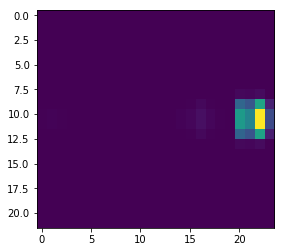

In [0]:
L = np.load('/gdrive/My Drive/periodic_tf/data/all/L_all.npy')
X = np.load('/gdrive/My Drive/periodic_tf/data/all/X_2d.npy')
y = np.load('/gdrive/My Drive/periodic_tf/data/all/y.npy')
max_ = 0
print(L.shape)
print(X.shape)
max_back = np.zeros((1,22,24))
for i in range(L.shape[1]):
    if np.sum(L[:,i]) > max_:
        max_ = np.sum(L[:,i])
        max_back = L[:,i].reshape((1,22,24))

for i in range(X.shape[0]):
    X[i] = (X[i] - max_back).clip(min=0)
    
np.save('/gdrive/My Drive/periodic_tf/data/all/X_2d_cad_trainonly.npy',X)
np.save('/gdrive/My Drive/periodic_tf/data/all/y_cad_trainonly.npy',y)
np.save('/gdrive/My Drive/periodic_tf/data/all/max_cad_back.npy',max_back)

import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(max_back[0])
plt.savefig('/gdrive/My Drive/periodic_tf/data/all/max_cad_back.png')

(528, 30593)
(528, 4658)
(528, 2420)
(528, 5433)
(528, 500)
(528, 1514)
(528, 512)


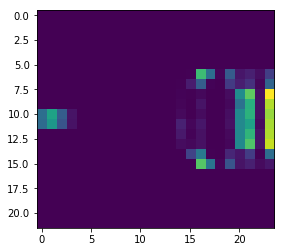

In [0]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

classes = [1,2,4,5,6,8,13]

for classnum in classes:
  L = np.load('/gdrive/My Drive/periodic_tf/data/all/L_'+str(classnum)+'_trainonly.npy')
  # X = np.load('/gdrive/My Drive/periodic_tf/data/all/X_2d.npy')
  # y = np.load('/gdrive/My Drive/periodic_tf/data/all/y.npy')
  max_ = 0
  print(L.shape)
  # print(X.shape)
  max_back = np.zeros((1,22,24))
  for i in range(L.shape[1]):
    if np.sum(L[:,i]) > max_:
      max_ = np.sum(L[:,i])
      max_back = L[:,i].reshape((1,22,24))
  
  plt.imshow(max_back[0])
  plt.savefig('/gdrive/My Drive/periodic_tf/data/all/max_cad_back_'+str(classnum)+'.png')
  np.save('/gdrive/My Drive/periodic_tf/data/all/max_cad_back_'+str(classnum)+'.npy',max_back)

  # for i in range(X.shape[0]):
  #     X[i] = (X[i] - max_back).clip(min=0)

  # np.save('/gdrive/My Drive/periodic_tf/data/all/X_2d_cad_trainonly.npy',X)
  # np.save('/gdrive/My Drive/periodic_tf/data/all/y_cad_trainonly.npy',y)
  # np.save('/gdrive/My Drive/periodic_tf/data/all/max_cad_back_'+str(classnum)+'.npy',max_back)

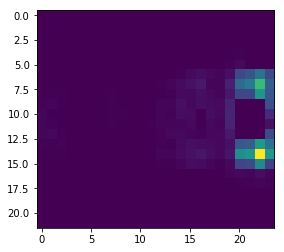

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.imshow(X[2])

In [0]:
main()

In [0]:
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline
max_back = np.load('/gdrive/My Drive/periodic_tf/data/all/max_cad_back.npy')

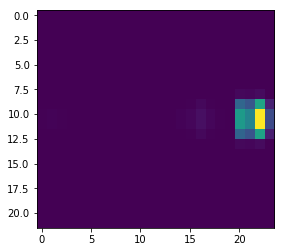

In [0]:
plt.imshow(max_back[0])

In [0]:
plt.savefig("/gdrive/My Drive/periodic_tf/data/all/max_cad_back.png")

<Figure size 432x288 with 0 Axes>

## Classes done - 1,2,4,5,6,8,13

## Section for storing random objects of each class

In [0]:
import matplotlib.pyplot as plt
import os

from pylab import * 
%matplotlib inline

In [0]:
L = np.load('L_%i_id.npy'%(1))
zeros = 0
for i in range(L.shape[1]):
    if np.linalg.norm(L[:,i])<=0.5:zeros+=1
        
print zeros
print L.shape[1]

In [0]:
back= np.load('L_cad_trainonly.npy')
max_ = 0
max_back = np.zeros((1,23,24))
for i in range(back.shape[1]):
    if np.sum(back[:,i])>max_:
        max_back = back[:,i].reshape((1,23,24))
        max_ = np.sum(back[:,i])
        
imsave('cadence_back.png',max_back.reshape((23,24)),vmin=0,vmax=3)


In [0]:
dmdt_orig = np.load('X_2d_normalized.npy')
labels = np.load('y_normalized.npy')
ids = np.load('ids.npy')
classes_done = [1,2,4,5,6,8,13]
for i in classes_done:
    
    mask = np.in1d(labels,i)
    dmdt = dmdt_orig[mask]
    #ids  = ids[mask]
    total_objects = dmdt.shape[0]
    
    
    
    
    path = 'samples_normalized%i'%(i)
    if os.path.exists(path)==False:os.makedirs(path)
    
    
    objects = np.random.randint(total_objects,size = 10)
    for id in objects:
        
        imsave(path+'/%i_orig.png'%(id),dmdt[id],vmin=0,vmax=0.025)

In [0]:
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import MiniBatchKMeans


# dmdt = np.load('X_2d_id.npy')
# labels = np.load('y_id.npy')
# ids = np.load('ids.npy')

dmdt = np.load('/gdrive/My Drive/periodic_tf/data/all/X_2d_cad_trainonly.npy')
labels = np.load('/gdrive/My Drive/periodic_tf/data/all/y_cad_trainonly.npy')

print(set(labels))

class_ = 2

mask = np.in1d(labels,class_)
temp = dmdt[mask]
X = np.zeros((temp.shape[0],22*24))
for i in range(temp.shape[0]):
  X[i,:] = temp[i].reshape((22*24))

kmeans = KMeans(n_clusters=2,random_state=0).fit(X)
minibatchkmeans = MiniBatchKMeans(n_clusters=2,random_state=0).fit(X)

{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17}


In [0]:
kmeans.inertia_/temp.shape[0]

167.74767532283082

In [0]:
kmeans.inertia_

781368.6716537459

In [0]:
minibatchkmeans.inertia_

783022.7622752588

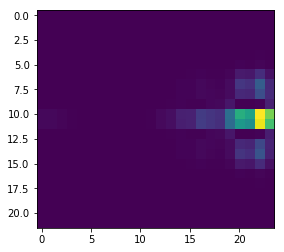

In [0]:
plt.imshow(kmeans.cluster_centers_[0].reshape((22,24)))
#plt.savefig('/gdrive/My Drive/periodic_tf/data/all/kmeans/EW/cluster_center_1.png')

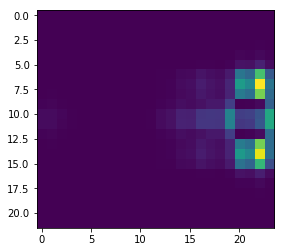

In [0]:
plt.imshow(kmeans.cluster_centers_[1].reshape((22,24)))
#plt.savefig('/gdrive/My Drive/periodic_tf/data/all/kmeans/EW/cluster_center_2.png')

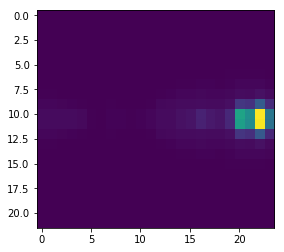

In [0]:
plt.imshow(kmeans.cluster_centers_[2].reshape((22,24)))

In [0]:
X = np.load('X_2d.npy')
y = np.load('y.npy')
for i in range(X.shape[0]):
    X[i,10:12,:] = np.zeros((2,24))
np.save('X_2d_blanked_2.npy',X)
np.save('y_blanked_2',y)

In [0]:
from matplotlib import pyplot

X = np.load('X_2d_test.npy')
y = np.load('y_test.npy')
X_miss = np.load('X_2d_test_fabian_normal_misclassified.npy')
y_miss = np.load('y_test_fabian_normal_misclassified.npy')

classes = [1,2,4,5,6,8,13]

for i in range(7):
    mask = np.in1d(y,i)
    temp = X[mask]
    
    mask_miss = np.in1d(y_miss,float(i))
    temp_miss = X_miss[mask_miss]
    
    hist = []
    for j in range(temp.shape[0]):
        hist.append(np.sum(temp[j]))
    
    hist_miss = []
    for j in range(temp_miss.shape[0]):
        hist_miss.append(np.sum(temp_miss[j]))
    pyplot.figure(figsize=(10,8))
    pyplot.hist(hist,bins=20,color='white',label='Total')
    pyplot.hist(hist_miss,bins=20,label='Misclassified')
    pyplot.suptitle('Class %i'%(classes[i]),fontsize=25,fontweight='bold')
    pyplot.xlabel('Number of dmdt pairs',fontsize=25,fontweight='bold')
    pyplot.ylabel('Number',fontsize=25,fontweight='bold')
    pyplot.tick_params(labelsize=25)
    pyplot.legend(loc='upper right')
    pyplot.savefig('class%i'%(classes[i]))

In [0]:
temp1 = np.load('X_2d.npy')
y = np.load('y.npy')
classes = [1,2,4,5,6,8,13]
for i in range(7):
    mask = np.in1d(y,classes[i])
    temp = temp1[mask]
    print temp.shape
    sum_ = np.zeros((1,temp.shape[1],temp.shape[2]))
    for j in range(temp.shape[0]):sum_+=temp[j]
    if classes[i]>=6:imsave('stacked_class%i.png'%(classes[i]),sum_.reshape((23,24)),vmin=0,vmax=4*temp.shape[0])
    else:imsave('stacked_class%i.png'%(classes[i]),sum_.reshape((23,24)),vmin=0,vmax=4*temp.shape[0])


In [0]:
!pip3 install scipy==1.1.0
!pip install texttable

     |████████████████████████████████| 31.2MB 64.7MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: scipy 1.3.0
    Uninstalling scipy-1.3.0:
      Successfully uninstalled scipy-1.3.0
  Created wheel for texttable: filename=texttable-1.6.2-cp36-none-any.whl size=10654 sha256=0a7139d0c307fed43b75b8fb49babf73bebefce12c73a80842ba3f8ef5a72cf9
  Stored in directory: /root/.cache/pip/wheels/51/d1/d6/dfbe4eb3c468832f7fbe4bd27f9875fa97277cabed8fb6715c
Successfully built texttable


In [0]:
import configparser
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from numpy import genfromtxt
from six.moves import cPickle
import os
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable
import statistics as stats
import glob
from texttable import Texttable

#import matplotlib
#matplotlib.use('Agg')

import copy
from sklearn import metrics
import seaborn
import tensorflow as tf
import keras
import keras.backend.tensorflow_backend as K
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dropout
from keras.layers import Dense, Activation
from keras.layers import Flatten
from keras.engine.topology import Input
from keras.optimizers import Adam
from keras import regularizers
from keras.models import load_model
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

from vis.visualization import visualize_activation, visualize_saliency, visualize_cam
from vis.utils import utils
from keras import activations

Using TensorFlow backend.


In [0]:
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.InputLayer(input_shape=(22,24,1)))
model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=(5, 5), activation="relu", 
                 #data_format = "channels_first",
                 kernel_regularizer=regularizers.l2(0.01), 
                 #input_shape=(23,24,1),
                 padding='valid',
                 name="conv2d1"))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), padding='valid', 
                 #data_format = "channels_first",
                 name="maxpool2d1",
                 strides=(2,2)))
#model.add(Dropout(rate=0.1))
model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(5, 5), activation="relu", 
                 kernel_regularizer=regularizers.l2(0.01),
                 padding='valid', 
                 #data_format = "channels_first",
                 name="conv2d2"))
#model.add(Conv2D(filters=256, kernel_size=(5, 5), activation="relu", kernel_regularizer=regularizers.l2(0.01)))
model.add(tf.keras.layers.Flatten(
    #data_format = "channels_first", 
    name="flatten"))
#model.add(Dense(units=512, kernel_regularizer=regularizers.l2(0.01)))
#model.add(Dropout(rate=0.5))
#model.add(Dense(units=512, kernel_regularizer=regularizers.l2(0.01)))
model.add(tf.keras.layers.Dense(units=7, activation="softmax", name="preds"))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.load_weights('/gdrive/My Drive/periodic_tf/code/experiments/cnn_22_w o_back_subtraction_float_bins/model.h5')
#model.load_weights('model.h5')
model.summary()

W0803 07:32:42.213408 140488809736064 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d1 (Conv2D)             (None, 18, 20, 16)        416       
_________________________________________________________________
maxpool2d1 (MaxPooling2D)    (None, 9, 10, 16)         0         
_________________________________________________________________
conv2d2 (Conv2D)             (None, 5, 6, 64)          25664     
_________________________________________________________________
flatten (Flatten)            (None, 1920)              0         
_________________________________________________________________
preds (Dense)                (None, 7)                 13447     
Total params: 39,527
Trainable params: 39,527
Non-trainable params: 0
_________________________________________________________________


In [0]:
# X = np.load("/gdrive/My Drive/periodic_tf/data/all/X_2d.npy")
# X = X.reshape((X.shape[0], X.shape[1], X.shape[2], 1))
# y = np.load("/gdrive/My Drive/periodic_tf/data/all/y.npy")
# mask = np.in1d(y, np.array([1,2,4,5,6,8,13]))
# y = y[mask]
# X = X[mask]

X = np.load("/gdrive/My Drive/periodic_tf/code/experiments/cnn_22_w o_back_subtraction_float_bins/X_test.npy")
y = np.load("/gdrive/My Drive/periodic_tf/code/experiments/cnn_22_w o_back_subtraction_float_bins/y_test.npy")

b1 = np.load("/gdrive/My Drive/periodic_tf/data/all/max_cad_back_1.npy")[0]
b2 = np.load("/gdrive/My Drive/periodic_tf/data/all/max_cad_back_2.npy")[0]
b4 = np.load("/gdrive/My Drive/periodic_tf/data/all/max_cad_back_4.npy")[0]
b5 = np.load("/gdrive/My Drive/periodic_tf/data/all/max_cad_back_5.npy")[0]
b6 = np.load("/gdrive/My Drive/periodic_tf/data/all/max_cad_back_6.npy")[0]
b8 = np.load("/gdrive/My Drive/periodic_tf/data/all/max_cad_back_8.npy")[0]
b13 = np.load("/gdrive/My Drive/periodic_tf/data/all/max_cad_back_13.npy")[0]

In [0]:
X.shape

(9126, 22, 24, 1)

In [0]:
import random 
i = random.randint(0, X.shape[0])
print("id:",i)
print("class:",y[i])
print("original probability:", model.predict(X)[i])
print("b1 probability:", model.predict((X[i,:,:,0]-b1).reshape(1, 22, 24, 1))[0])
print("b2 probability:", model.predict((X[i,:,:,0]-b2).reshape(1, 22, 24, 1))[0])
print("b4 probability:", model.predict((X[i,:,:,0]-b4).reshape(1, 22, 24, 1))[0])
print("b5 probability:", model.predict((X[i,:,:,0]-b5).reshape(1, 22, 24, 1))[0])
print("b6 probability:", model.predict((X[i,:,:,0]-b6).reshape(1, 22, 24, 1))[0])
print("b8 probability:", model.predict((X[i,:,:,0]-b8).reshape(1, 22, 24, 1))[0])
print("b13 probability:", model.predict((X[i,:,:,0]-b13).reshape(1, 22, 24, 1))[0])

id: 25389
class: 5
original probability: [1.4081006e-01 3.1128522e-05 5.8445606e-02 7.7623147e-01 1.0013879e-02
 1.4459295e-02 8.5892752e-06]
b1 probability: [5.7529800e-37 0.0000000e+00 2.0680070e-15 7.6106021e-35 0.0000000e+00
 2.6740075e-29 1.0000000e+00]
b2 probability: [1.3204959e-01 8.2088780e-01 1.0057952e-02 3.6956146e-02 1.3754397e-05
 3.4650675e-05 4.3011184e-08]
b4 probability: [6.0336769e-01 4.8279013e-03 2.4809856e-02 3.5929039e-01 1.5785071e-03
 6.1195320e-03 6.0874891e-06]
b5 probability: [2.1821710e-01 7.3895192e-01 1.5436496e-02 2.7152048e-02 2.6186388e-05
 2.1607871e-04 1.6109934e-07]
b6 probability: [1.4422817e-02 1.3768260e-04 3.5603538e-02 8.9921772e-01 2.0023763e-04
 5.0399013e-02 1.8942546e-05]
b8 probability: [1.2624075e-05 6.6476218e-07 2.6672666e-05 1.3290472e-04 4.0039051e-08
 9.9982697e-01 2.4896323e-07]
b13 probability: [9.0573519e-01 6.5300272e-05 1.3076155e-03 9.2844658e-02 6.2227555e-06
 4.0950155e-05 2.4496098e-09]


In [0]:
pd={1:0,2:1,4:2,5:3,6:4,8:5,13:6}
cls = 1
mis_cls = 8
y_cls = np.where(y==cls)[0]
res = []
for i in y_cls:
  og = model.predict(X)[i]
  b1p = model.predict((X[i,:,:,0]-b1).reshape(1, 22, 24, 1))[0]
  b2p = model.predict((X[i,:,:,0]-b2).reshape(1, 22, 24, 1))[0]
  b4p = model.predict((X[i,:,:,0]-b4).reshape(1, 22, 24, 1))[0]
  b5p = model.predict((X[i,:,:,0]-b5).reshape(1, 22, 24, 1))[0]
  b6p = model.predict((X[i,:,:,0]-b6).reshape(1, 22, 24, 1))[0]
  b8p = model.predict((X[i,:,:,0]-b8).reshape(1, 22, 24, 1))[0]
  b13p = model.predict((X[i,:,:,0]-b13).reshape(1, 22, 24, 1))[0]
  if np.argmax(og)!=pd[cls] and max(b1p[pd[cls]], b2p[pd[cls]], b4p[pd[cls]], b5p[pd[cls]], b6p[pd[cls]], b8p[pd[cls]], b13p[pd[cls]]) == b8p[pd[cls]]:
    print(i)
    res.append(i)
res = np.array(res)

489
5708


In [0]:
res.shape

(2,)

true class = 5, Prediction = 1: 10/228\
true class = 1, Prediction = 5: 211/226\
true class = 2, Prediction = 1: 43/218\
true class = 8, Prediction = 1: 43/216\
true class = 1, Prediction = 2: 1/116\
true class = 4, Prediction = 5: 35/92\
true class = 4, Prediction = 1: 21/84\
true class = 1, Prediction = 4: 27/69\
true class = 6, Prediction = 5: 0/60\
true class = 1, Prediction = 8: 2/56\
true class = 5, Prediction = 4: 12/46\
true class = 8, Prediction = 5: 0/23\
true class = 6, Prediction = 1: 0/12


